# Forecasting Natural gas prices

In [375]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import chart_studio.plotly as py
import plotly.graph_objects as go

pd.options.mode.chained_assignment = None

In [2]:
seed = 42

# Analise de Dados

## Carregando base de dados

In [217]:
daily_prices = pd.read_csv('daily_csv.csv',',')

In [218]:
daily_prices.tail()

Date  Price
5938  2020-08-12   2.05
5939  2020-08-13   2.19
5940  2020-08-14   2.23
5941  2020-08-17   2.32
5942  2020-08-18   2.45

In [219]:
daily_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5943 entries, 0 to 5942
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5943 non-null   object 
 1   Price   5942 non-null   float64
dtypes: float64(1), object(1)
memory usage: 93.0+ KB


In [220]:
daily_prices.shape

(5943, 2)

In [221]:
daily_prices.isnull().sum()

Date     0
Price    1
dtype: int64

In [222]:
daily_prices['Date'] = pd.to_datetime(daily_prices['Date'])

In [223]:
daily_prices = daily_prices.dropna()

## Entendo a distribuição dos Dados

In [224]:
daily_prices['year'] = daily_prices['Date'].dt.year
daily_prices['month'] = daily_prices['Date'].dt.month

In [225]:
yearly_avg = pd.DataFrame(daily_prices.groupby('year')['Price'].mean()).reset_index()
monthly_avg = pd.DataFrame(daily_prices.groupby(['year','month'])['Price'].mean()).reset_index()

In [226]:
monthly_avg.head()

year  month     Price
0  1997      1  3.451053
1  1997      2  2.150526
2  1997      3  1.890500
3  1997      4  2.032727
4  1997      5  2.248095

In [227]:
yearly_avg.head()

year     Price
0  1997  2.489839
1  1998  2.088367
2  1999  2.274120
3  2000  4.311486
4  2001  3.959120

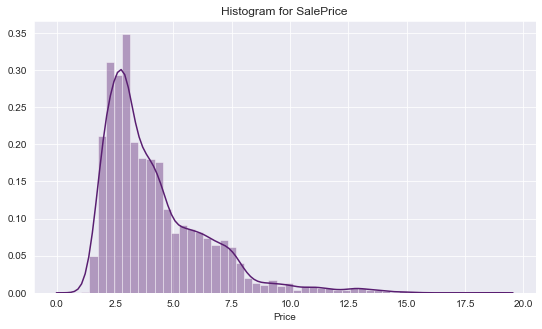

In [228]:
# Setting the grid style
sns.set_style('darkgrid')
sns.set_color_codes(palette='dark')

# Setting plot area
f, ax = plt.subplots(figsize=(9, 5))

# plotting the distribution plot
sns.distplot(daily_prices['Price'], color="m", axlabel='Price')
ax.set(title="Histogram for SalePrice")
plt.show()

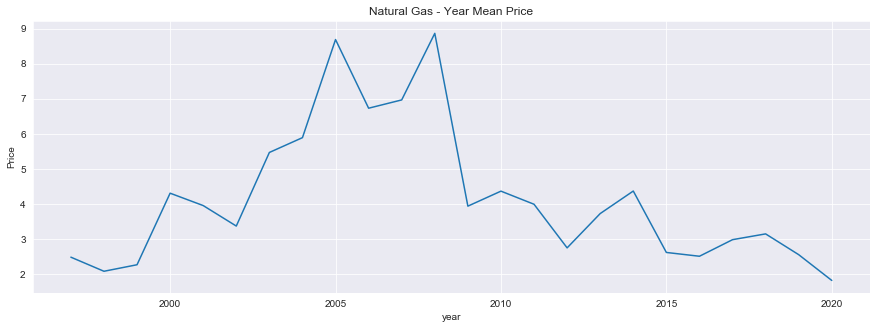

In [229]:
f, axes = plt.subplots(1, figsize=(15,5))

sns.lineplot(x="year", y="Price",data=yearly_avg)

plt.title("Natural Gas - Year Mean Price")

plt.show()

In [230]:
month_price = daily_prices.set_index('Date').resample('M')['Price'].agg({'mean','std'}).reset_index()
month_price['cv'] = (month_price['std']/month_price['mean'])

month_price.head()

Date      mean       std        cv
0 1997-01-31  3.451053  0.602448  0.174569
1 1997-02-28  2.150526  0.311653  0.144919
2 1997-03-31  1.890500  0.060652  0.032083
3 1997-04-30  2.032727  0.096174  0.047313
4 1997-05-31  2.248095  0.049962  0.022224

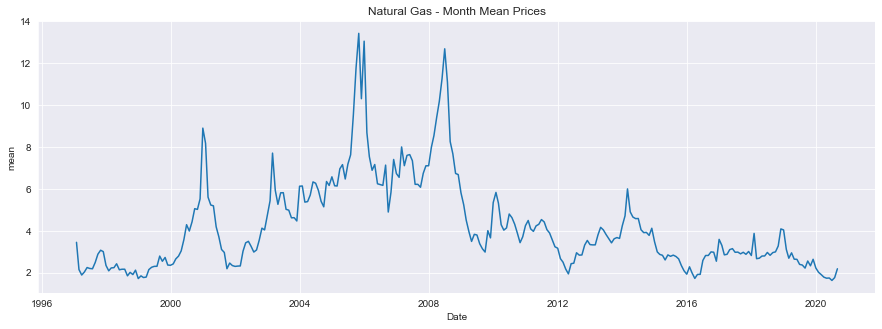

In [231]:
f, axes = plt.subplots(1, figsize=(15,5))

sns.lineplot(x="Date", y="mean",data=month_price)

plt.title("Natural Gas - Month Mean Prices")

plt.show()

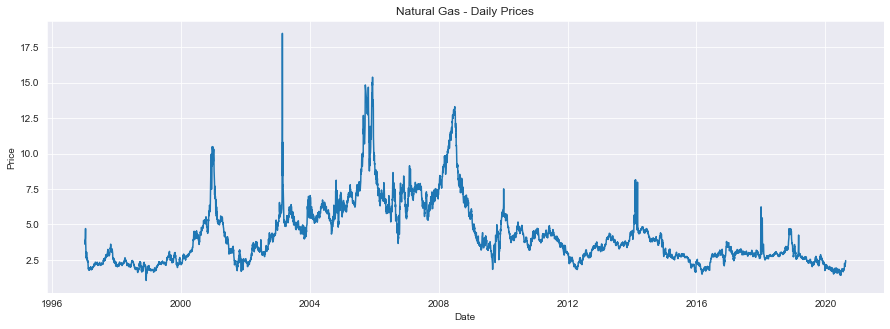

In [232]:
f, axes = plt.subplots(1, figsize=(15,5))

sns.lineplot(x="Date", y="Price",data=daily_prices)

plt.title("Natural Gas - Daily Prices")

plt.show()

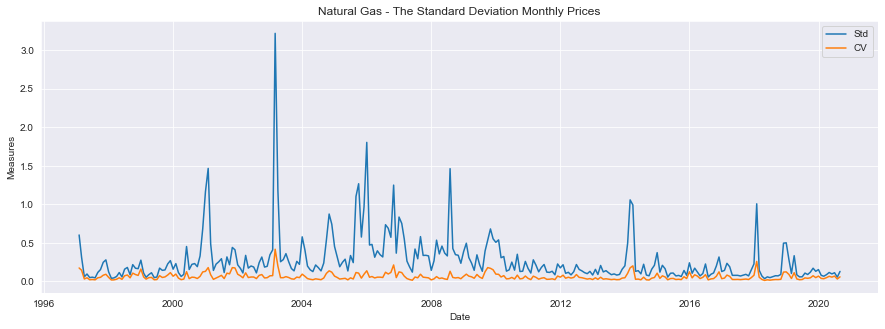

In [233]:

f, axes = plt.subplots(1, figsize=(15,5))

sns.lineplot(x="Date", y="std",label ='Std',data=month_price)
sns.lineplot(x="Date", y="cv",label ='CV',data=month_price)

plt.ylabel('Measures')

plt.title("Natural Gas - The Standard Deviation Monthly Prices")

plt.show()

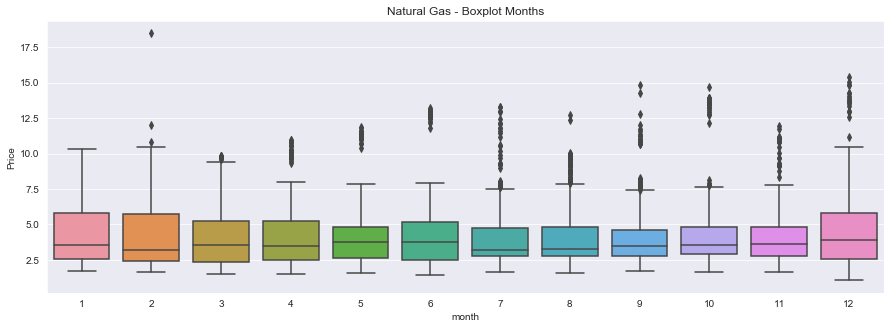

In [234]:
f, axes = plt.subplots(1, figsize=(15,5))

sns.boxplot(x="month", y="Price", data=daily_prices)


plt.title("Natural Gas - Boxplot Months")

plt.show()

## Remoção de Outliers

### Lowest quantile and the highest quantile

Para fins de demonstração, defina a variável y para o eixo y, remova os números no primeiro e último quantil e, em excesso, no gráfico resultante, removed_outliers, no gráfico anterior.

In [376]:
daily_prices_remOutliers = daily_prices[['Date','Price']]
size = daily_prices.size
y = daily_prices_remOutliers['Price']
removed_outliers = y.between(y.quantile(.05), y.quantile(.95))

print(str(y[removed_outliers].size) + "/" + str(size) + " data points remain.")

print(str((100-(y[removed_outliers].size/size)*100)) +  " remained data points from Dataset.")


5350/23768 data points remain.
77.4907438572871 remained data points from Dataset.


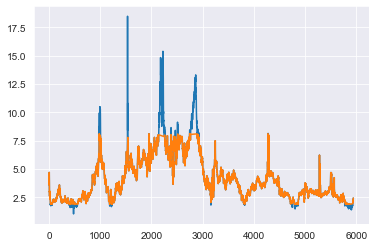

In [377]:
daily_prices['Price'].plot().get_figure()
y[removed_outliers].plot().get_figure()
plt.show()

In [378]:
print(removed_outliers.value_counts())

True     5350
False     592
Name: Price, dtype: int64


In [379]:
index_names = daily_prices[~removed_outliers].index # INVERT removed_outliers!!
print(index_names)

Int64Index([  29,   34,   35,   36,   37,   38,   39,   41,   50,   51,
            ...
            5921, 5922, 5923, 5924, 5925, 5926, 5927, 5928, 5929, 5930],
           dtype='int64', length=592)


In [380]:
daily_prices_remOutliers.drop(index_names, inplace=True)

In [381]:
daily_prices_remOutliers.head()

Date  Price
0 1997-01-07   3.82
1 1997-01-08   3.80
2 1997-01-09   3.61
3 1997-01-10   3.92
4 1997-01-13   4.00

In [382]:
trace = go.Scatter(
   x = daily_prices_remOutliers['Date'],
   y = daily_prices_remOutliers['Price'])

go.Figure(data=[trace])

### Turkey Method

MEtodo de Turkey 



In [383]:
def detect_outliers(df, n, features):

    outlier_indices = []

    for col in features:

        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)

        IQR = Q3 - Q1
        print('\n',col)

        outlier_step = 1.5 * IQR

        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        print(outlier_list_col)
        outlier_indices.extend(outlier_list_col)
    
    return outlier_indices

In [496]:

lof = ['Price']
daily_prices_tkm = daily_prices[['Date','Price']]
Outliers_to_drop = detect_outliers(daily_prices_tkm, 1, lof)


 Price
Int64Index([ 985,  990,  991,  992,  993,  994,  995,  996,  997,  998,
            ...
            2877, 2878, 2879, 2880, 2881, 2882, 2883, 2884, 2886, 2888],
           dtype='int64', length=218)


In [497]:
daily_prices_tkm.drop(Outliers_to_drop,inplace=True)

In [498]:
y = daily_prices['Price']

print(str(y[Outliers_to_drop].size) + "/" + str(size) + " data points remain.")
print("Turkey Method, " + str(100-((y[Outliers_to_drop].size/size)*100)) +  " % of remained data points from Dataset.")

218/23768 data points remain.
Turkey Method, 99.08280040390441 % of remained data points from Dataset.


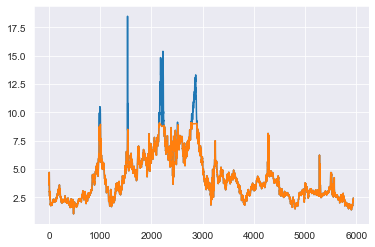

In [499]:
daily_prices['Price'].plot().get_figure()
daily_prices_tkm['Price'].plot().get_figure()
plt.show()

## Hypothesis Test

Vamos entender como o teste Dickey-Fuller pode nos ajudar. Este é um teste estatístico, onde a hipótese nula afirma que existe uma raiz unitária para a série (não estacionaria), enquanto a hipótese alternativa afirma que a série é estacionária. 

Uma série temporal é dita estacionária quando ela se desenvolve no tempo aleatoriamente ao redor de uma média constante, refletindo alguma forma de equilíbrio estável. Na prática, a maioria das séries que encontramos apresentam algum tipo de não estacionariedade, por exemplo, tendência.

Portanto para garantir a estacionaridade devemos atender a 3 pontos:
1. A media dos valores da sua serie deve ser constante no tempo
2. O desvio padrão (variancia) desta serie tambem deve ser constante no tempo
3. Por ultimo, não haver componentes de sacionalidade.



Sobre a serie aplicaremos o teste de hipotese utilizando o Teste de Dickey Fuller, um teste autogressivo de primeira ordem, onde testamos a hiposte a1 = 0, sendo a hipotese alternativa a1 < 0 dizemos que a serie é estacionaria. Caso não pudermos rejeita a hipoteses nula, dizemos que esta seroe possui raiz unitaria.

Portanto nossa hipotese ficaria

* H0 = Serie possui raiz unitaria
* H1 = Serie Estacionaria

Porem, antes de continuarmos, é importante explicar a definição de uma raiz unitaria.

Uma raiz unitária se refere a uma tendência estocástica, cujo estado é indeterminado, com origem em eventos aleatórios (jogar dados), em séries temporais. De maneira mais pratica, uma série temporal é um processo que pode ser escrito por componentes que contém "raízes". Por exemplo:

vt= c + a1vt − 1 + ϵt − 1

O coeficiente a1 é uma raiz. Podemos interpretar esta fórmula como "o valor de hoje depende do valor de ontem e alguma aleatoriedade que não podemos prever", podemos notar que representa uma regressão. Sendo assim, é esperado que esta formula convirja de volta para o valor de c.

Suponha que c = 0 e a1 = 0,5. Se ontem (vt − 1) o valor era 50, então esperamos que hoje o valor seja em torno de 25. No dia seguinte, esperamos que o valor seja 12,5 e assim por diante. Isso significa que irá sempre convergir e voltar para o valor de c.

Quando uma das raízes é uma unidade, ou seja, igual a 1 (neste exemplo, quando a1 = 1), essa série não se recuperará de sua origem c. É por isso que os conceitos de raízes unitárias e testes de raiz unitária são úteis: eles nos fornecem insights sobre se a série temporal irá se recuperar ao seu valor esperado. Se não for esse o caso, o processo será muito suscetível a choques e difícil de prever e controlar.


Chega de Teoria! Vamos a pratica!

https://faculty.chicagobooth.edu/ruey.tsay/teaching/uts/lec11-08.pdf

tendencia estocastica


In [436]:
import statsmodels.tsa.stattools as tsa

In [509]:
def adf_test(dataset, log_test = False):
    ds = dataset
    
    if log_test:
        ds = np.log(ds)
        ds.dropna(inplace=True)
    
    alpha = 0.05
    
    result = tsa.adfuller(ds)
    print('Augmented Dickey-Fuller Test')
    print('test statistic: %.10f' % result[0])
    print('p-value: %.10f' % result[1])
    print('critical values')
    
    for key, value in result[4].items():
        print('\t%s: %.10f' % (key, value))
        
    if result[1] < alpha:  #valor de alpha é 0.05 ou 5 %
        print("Rejeitamos a Hipotese Nula")
    else:
        print("Aceitamos a Hipotese Nula")
            

### Fuller Test - Removed Outlier Dataset 

In [504]:
adf_test(daily_prices_tkm['Price'], True)

Augmented Dickey-Fuller Test
test statistic: -2.4891992541
p-value: 0.1181244286
critical values
	1%: -3.4314999830
	5%: -2.8620481817
	10%: -2.5670405034
Aceitamos a Hipotese Nula


Testamos o conjunto de dados original, bem como o conjunto de dados transformado em log, mas nossa série temporal ainda não é estacionária.
Que outras opções temos? Podemos aplicar outras técnicas que transformam os dados, sem alterar suas propriedades:

* Diferenciação: que subtraia cada ponto de dados pelo valor de um ponto de tempo específico na série, por exemplo, sempre subtraia pelo valor do próximo período
* Decomposição: que isola cada componente da série temporal como tendência, sazonalidade, ciclo, irregularidade

Em nosso caso, vamos tentar diferenciar o conjunto de dados.

Como diferenciar é subtrair, vamos mantê-lo simples e começar diferenciando cada ponto de dados do ponto de dados anterior a ele, ou seja, diferenciar valores consecutivos.

In [505]:
pd.DataFrame(data=np.diff(np.array(daily_prices_tkm['Price'])))
n_diff_dataset.columns = ['Price']

In [516]:
adf_test(n_diff_dataset['Price'],False)

Augmented Dickey-Fuller Test
test statistic: -16.1544548368
p-value: 0.0000000000
critical values
	1%: -3.4314999830
	5%: -2.8620481817
	10%: -2.5670405034
Rejeitamos a Hipotese Nula


Um valor de p menor que 0,05 implica significância e menor que 0,01 implica significância alta. Portanto, p = 0,0000 implica alta significância.

Nossa série temporal é finalmente estacionária, após a diferenciação. Mas se assim não fosse, poderíamos tentar continuar diferenciando as séries temporais.
Diferenciar não significa que você está subtraindo o valor de n períodos anteriores ou subtraindo valores defasados. Essa é a diferença sazonal.

### Fuller Test - Original DataSet

In [519]:
adf_test(daily_prices['Price'],False)

Augmented Dickey-Fuller Test
test statistic: -2.9463076065
p-value: 0.0402219955
critical values
	1%: -3.4314571489
	5%: -2.8620292567
	10%: -2.5670304291
Rejeitamos a Hipotese Nula


Um valor de p menor que 0,05 implica significância e menor que 0,01 implica significância alta. Portanto, p = 0,0000 implica alta significância.

Nossa série temporal é finalmente estacionária, após a diferenciação. Mas se assim não fosse, poderíamos tentar continuar diferenciando as séries temporais.
Diferenciar não significa que você está subtraindo o valor de n períodos anteriores ou subtraindo valores defasados. Essa é a diferença sazonal.

## Training Models

### Prophet Facebook

In [7]:
#pip install fbprophet
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [19]:
from fbprophet.plot import plot_plotly, plot_components_plotly

#import plotly.offline as py
#import plotly.graph_objs as go

In [520]:
prior_scale=0.2
daily_prices_prophet = daily_prices_tkm[['Date','Price']]

In [521]:
m = Prophet(changepoint_prior_scale=prior_scale)
daily_prices_prophet.columns = ['ds','y']
m.fit(daily_prices_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [522]:
future = m.make_future_dataframe(periods=365)
future.tail()

ds
6084 2021-08-14
6085 2021-08-15
6086 2021-08-16
6087 2021-08-17
6088 2021-08-18

In [523]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
6084 2021-08-14  2.968255    1.468236    4.326371
6085 2021-08-15  1.736839    0.321326    3.162372
6086 2021-08-16  2.366698    0.806692    3.824800
6087 2021-08-17  2.370812    0.821944    3.790535
6088 2021-08-18  2.367153    0.882490    3.761222

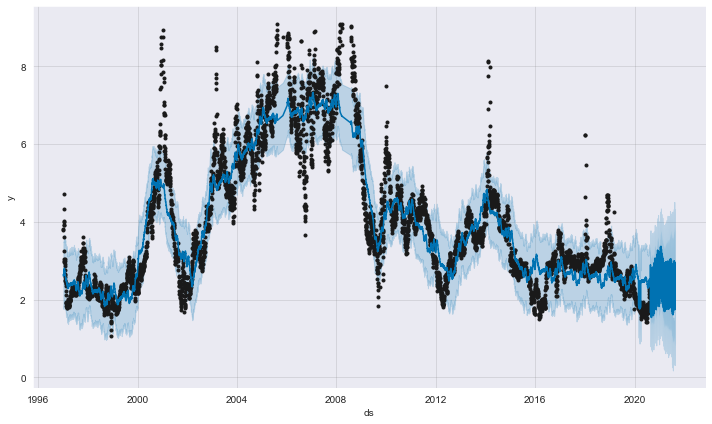

In [524]:
fig1 = m.plot(forecast)

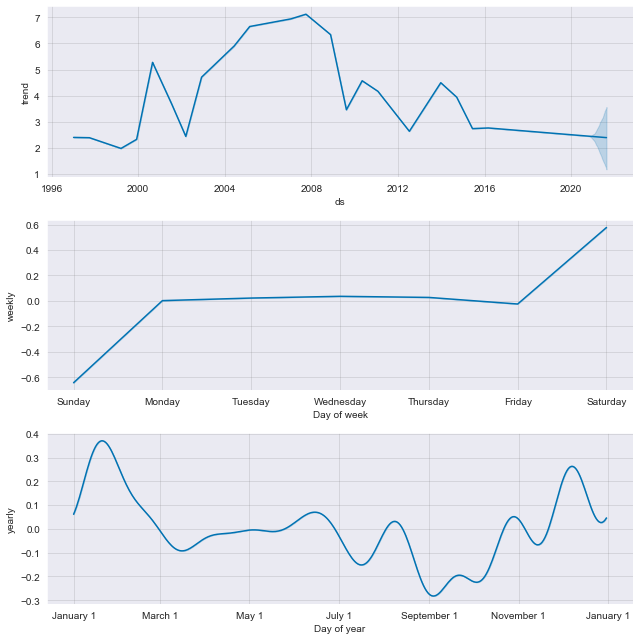

In [525]:
fig2 = m.plot_components(forecast)

#### Usando Plotly

Esta é uma bilioteca grafica jasldkasdkladsaçk

In [526]:
fig = go.Figure(data=[go.Table(
    header=dict(values=list(forecast[['ds','yhat','yhat_lower','yhat_upper']]),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[forecast.ds,forecast.yhat,forecast.yhat_lower, forecast.yhat_upper],
               fill_color='lavender',
               align='left'))
])

fig.show()

In [527]:
#plot_components_plotly(m, forecast)# Create traces
fig = go.Figure()

fig.add_trace(go.Scatter(x=daily_prices_prophet['ds'], y=daily_prices_prophet['y'],
                    mode='lines', name='Real'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'],
                    mode='lines',
                    name='Predito'))

fig.show()

#### Built-in Country Holidays

In [529]:
m = Prophet(changepoint_prior_scale=prior_scale)
m.add_country_holidays(country_name='US')
m.fit(daily_prices_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [530]:
m.train_holiday_names

0                  New Year's Day
1      Martin Luther King Jr. Day
2           Washington's Birthday
3                    Memorial Day
4                Independence Day
5                       Labor Day
6                    Columbus Day
7                    Veterans Day
8                    Thanksgiving
9                   Christmas Day
10    Independence Day (Observed)
11      New Year's Day (Observed)
12       Christmas Day (Observed)
13        Veterans Day (Observed)
dtype: object

In [531]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
6084 2021-08-14  2.969375    1.583574    4.418101
6085 2021-08-15  1.740934    0.342628    3.118161
6086 2021-08-16  2.368266    0.806978    3.742285
6087 2021-08-17  2.372409    0.881141    3.794401
6088 2021-08-18  2.368724    1.002387    3.755559

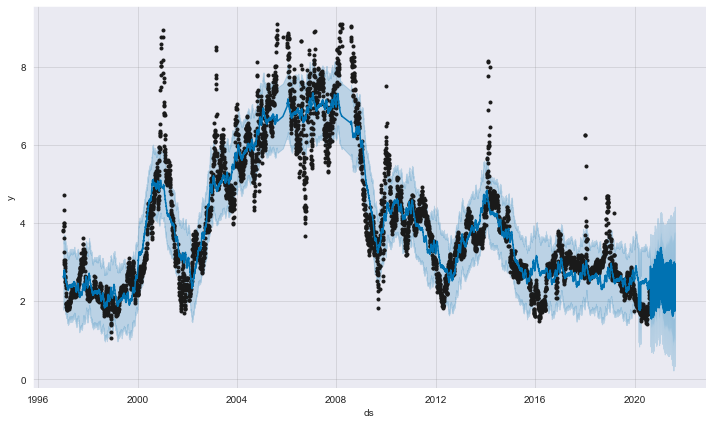

In [532]:
fig1 = m.plot(forecast)

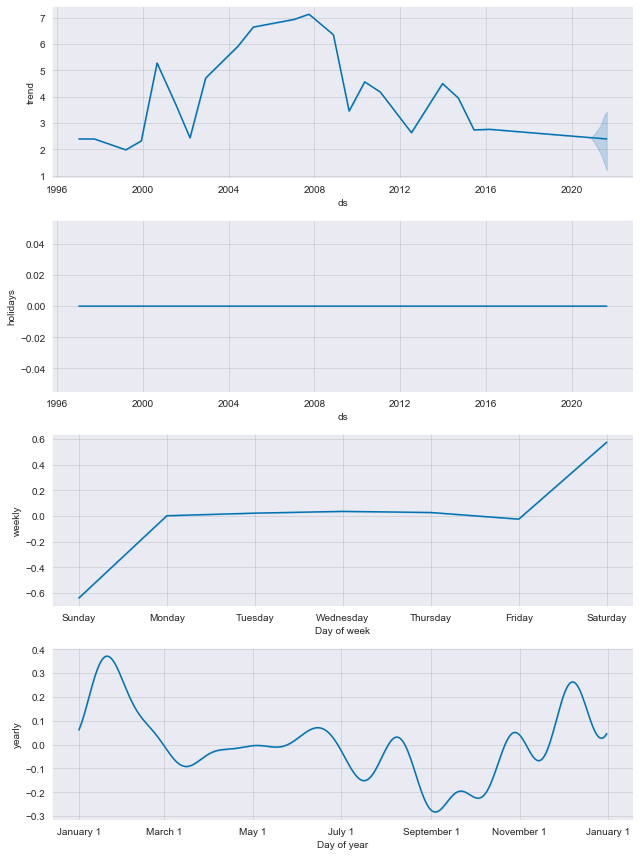

In [533]:
fig = m.plot_components(forecast)

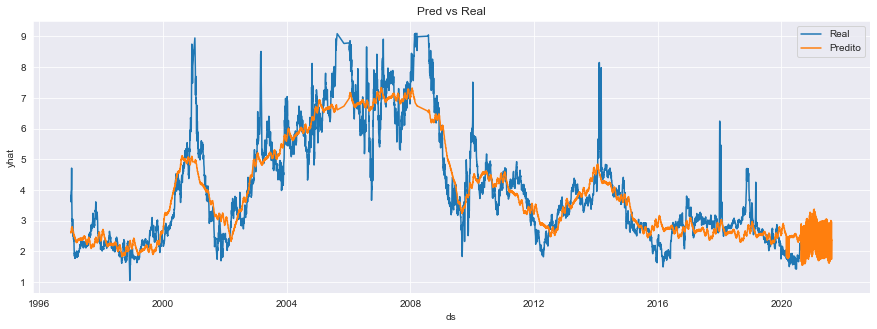

In [536]:
f, axes = plt.subplots(1, figsize=(15,5))

sns.lineplot(x="ds", y="y",label="Real", data=daily_prices_prophet)
sns.lineplot(x="ds", y="yhat",label="Predito",data=forecast)
#sns.lineplot(x="ds", y=daily_prices_prophet['y']-forecast['yhat'],label="Diff",data=forecast)

plt.title("Pred vs Real")

plt.show()

In [548]:
diff = daily_prices_prophet
diff['diff'] = forecast['yhat']-daily_prices_prophet['y']
diff.tail()

ds     y      diff
5938 2020-08-12  2.05 -0.349467
5939 2020-08-13  2.19  0.155807
5940 2020-08-14  2.23  0.139725
5941 2020-08-17  2.32  0.067315
5942 2020-08-18  2.45 -0.067136

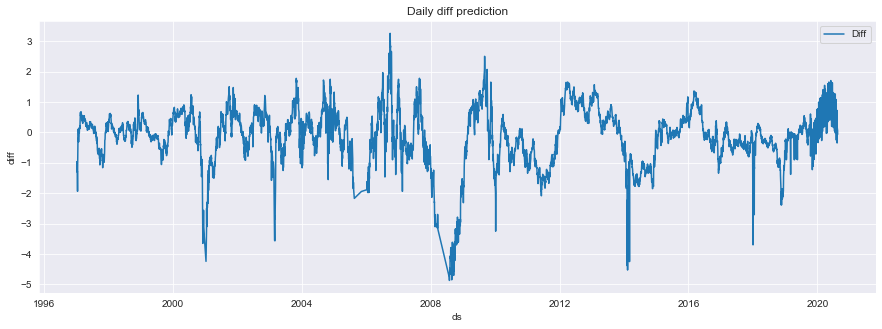

In [549]:
f, axes = plt.subplots(1, figsize=(15,5))

sns.lineplot(x="ds", y='diff',label="Diff",data=diff)

plt.title("Daily diff prediction")

plt.show()

#### Cross Validation

In [31]:
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation

In [32]:
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')

INFO:fbprophet:Making 42 forecasts with cutoffs between 1999-06-05 00:00:00 and 2019-08-19 00:00:00


In [33]:
df_cv.head()

ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1999-06-07  2.327225    2.145473    2.540186  2.41 1999-06-05
1 1999-06-08  2.342325    2.112246    2.560575  2.38 1999-06-05
2 1999-06-09  2.360149    2.129780    2.578315  2.39 1999-06-05
3 1999-06-10  2.360470    2.160138    2.572325  2.37 1999-06-05
4 1999-06-11  2.342134    2.114337    2.558013  2.30 1999-06-05

In [39]:
df_p = performance_metrics(df_cv)
df_p.head()

horizon       mse      rmse       mae      mape     mdape  coverage
0 37 days  2.581171  1.606602  1.132256  0.263791  0.203914  0.667952
1 38 days  2.635471  1.623413  1.144536  0.265797  0.204029  0.666220
2 39 days  2.714949  1.647710  1.158275  0.267822  0.205172  0.665272
3 40 days  2.745668  1.657006  1.163582  0.267842  0.206237  0.664423
4 41 days  2.772939  1.665214  1.169944  0.269230  0.207045  0.661864

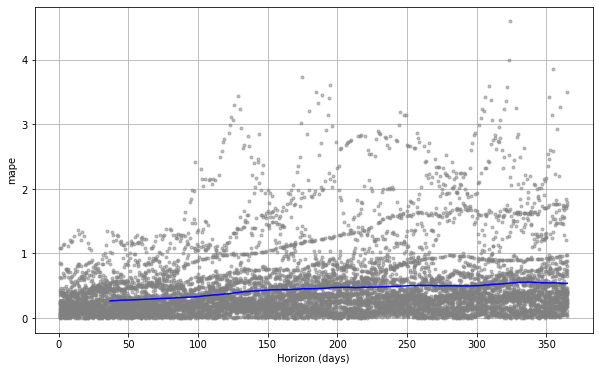

In [35]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')


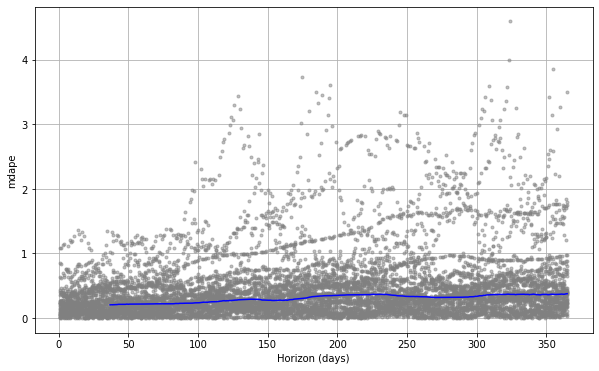

In [36]:
fig = plot_cross_validation_metric(df_cv, metric='mdape')


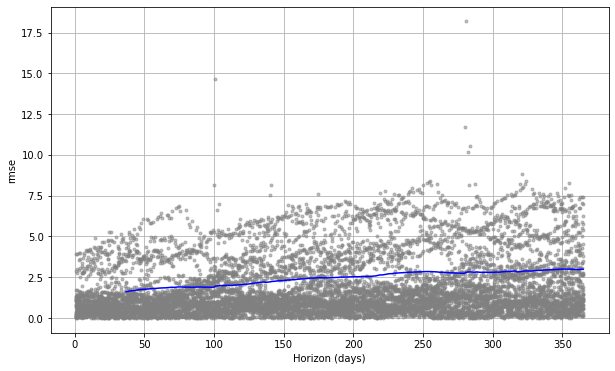

In [37]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

### Arima - AutoRegression